# Notebook 09: 3-Class Engagement Classification
## LinkedIn Engagement Prediction — TrendPilot

**Approach:** Relative Engagement Classification (Below / Average / Above Baseline)
**Date:** February 2026
**Follows:** `08_model_training_loo_relative.ipynb`
**Plan doc:** `reports/08_model_improvement_PLAN.md`

---

## Why Classification?

In Notebook 08 we predict the exact log-relative engagement as a regression target. This notebook asks a simpler, more robust question: **will this post under-perform, perform at average, or outperform the author's typical engagement?**

**Why classification may work better here:**
1. **Regression is hard** — predicting exact ratios requires precise numerical accuracy. Classification only needs to get the *tier* right.
2. **More actionable** — "this post will be above average" is more useful to a content creator than "this post will get 1.43x your median reactions"
3. **More robust to outliers** — the class boundaries absorb some of the remaining variance
4. **Natural imbalance** — viral (Class 2) posts are rare; we can handle this explicitly with class weights

**Class Definition (based on relative ratio from LOO normalisation):**

| Class | Label | Relative Ratio | Meaning |
|-------|-------|---------------|---------|
| 0 | Below Average | ratio < 0.75 | Post underperformed by more than 25% |
| 1 | Average | 0.75 <= ratio < 1.5 | Post within 50% band of author's typical |
| 2 | Above Average | ratio >= 1.5 | Post outperformed by more than 50% |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, accuracy_score, ConfusionMatrixDisplay)
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
print("Libraries loaded.")


Libraries loaded.


## 1. Load Data and Compute LOO Baselines

In [2]:
df = pd.read_csv('../data/selected_features_data.csv')
print(f"Shape: {df.shape}")

def compute_loo_medians(df, author_col='name'):
    global_med_r = df['reactions'].median()
    global_med_c = df['comments'].median()
    loo_r, loo_c = [], []
    for idx, row in df.iterrows():
        others = df[(df[author_col] == row[author_col]) & (df.index != idx)]
        if len(others) >= 2:
            loo_r.append(others['reactions'].median())
            loo_c.append(others['comments'].median())
        else:
            loo_r.append(global_med_r)
            loo_c.append(global_med_c)
    df = df.copy()
    df['loo_median_reactions'] = loo_r
    df['loo_median_comments']  = loo_c
    return df

print("Computing LOO baselines...")
df = compute_loo_medians(df)
print("Done.")


Shape: (772, 94)
Computing LOO baselines...
Done.


## 2. Class Label Creation

The class thresholds are set to create meaningful tiers:
- **< 0.75** (below average): post clearly underperformed — a signal something was off
- **0.75 to 1.5** (average): post performed within a reasonable band of the author's typical
- **>= 1.5** (above average): post outperformed — content drove genuine uplift

These thresholds are informed by the log-relative distribution and can be adjusted.


In [3]:
df['relative_reactions'] = df['reactions'] / df['loo_median_reactions']
df['relative_comments']  = (df['comments'] + 1) / (df['loo_median_comments'] + 1)

# 3-class labels
BINS  = [0, 0.75, 1.5, np.inf]
LABELS_3 = [0, 1, 2]
LABEL_NAMES = {0: 'Below Average (<0.75x)', 1: 'Average (0.75-1.5x)', 2: 'Above Average (>=1.5x)'}

df['class_reactions'] = pd.cut(df['relative_reactions'], bins=BINS, labels=LABELS_3).astype(int)
df['class_comments']  = pd.cut(df['relative_comments'],  bins=BINS, labels=LABELS_3).astype(int)

# Binary labels (below vs at/above)
df['binary_reactions'] = (df['relative_reactions'] >= 1.0).astype(int)
df['binary_comments']  = (df['relative_comments']  >= 1.0).astype(int)

print("Class distribution -- REACTIONS:")
for c, n in LABEL_NAMES.items():
    count = (df['class_reactions'] == c).sum()
    pct   = count / len(df) * 100
    print(f"  Class {c} ({n}): {count:4d} posts ({pct:.1f}%)")

print("\nClass distribution -- COMMENTS:")
for c, n in LABEL_NAMES.items():
    count = (df['class_comments'] == c).sum()
    pct   = count / len(df) * 100
    print(f"  Class {c} ({n}): {count:4d} posts ({pct:.1f}%)")

print("\nBinary distribution -- REACTIONS:")
for v, lbl in [(0,'Below baseline (<1.0x)'), (1,'At/Above baseline (>=1.0x)')]:
    count = (df['binary_reactions'] == v).sum()
    print(f"  {lbl}: {count} posts ({count/len(df)*100:.1f}%)")


Class distribution -- REACTIONS:
  Class 0 (Below Average (<0.75x)):  283 posts (36.7%)
  Class 1 (Average (0.75-1.5x)):  184 posts (23.8%)
  Class 2 (Above Average (>=1.5x)):  305 posts (39.5%)

Class distribution -- COMMENTS:
  Class 0 (Below Average (<0.75x)):  282 posts (36.5%)
  Class 1 (Average (0.75-1.5x)):  175 posts (22.7%)
  Class 2 (Above Average (>=1.5x)):  315 posts (40.8%)

Binary distribution -- REACTIONS:
  Below baseline (<1.0x): 348 posts (45.1%)
  At/Above baseline (>=1.0x): 424 posts (54.9%)


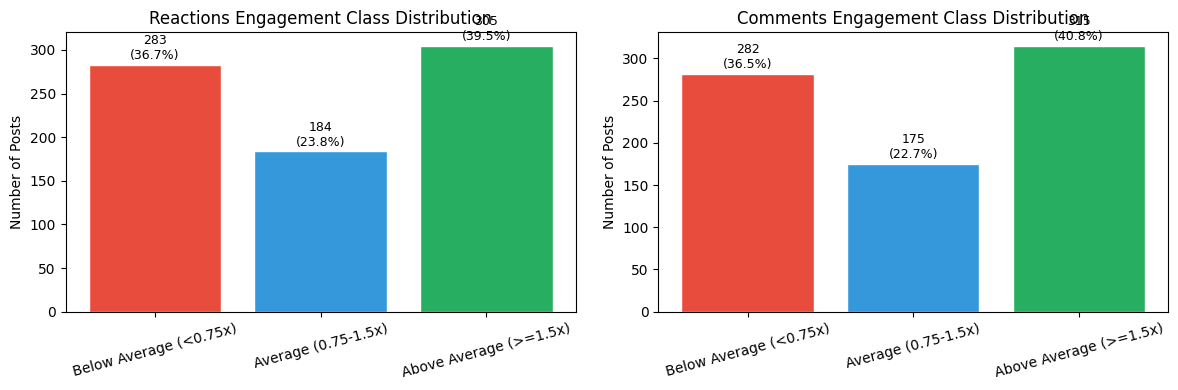

Saved: ../data/09_class_distribution.png


In [4]:
# Visualise class distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colours = ['#e74c3c','#3498db','#27ae60']

for ax, col, title in zip(axes,
    ['class_reactions', 'class_comments'],
    ['Reactions', 'Comments']):
    counts = df[col].value_counts().sort_index()
    bars = ax.bar([LABEL_NAMES[i] for i in counts.index], counts.values,
                  color=[colours[i] for i in counts.index], edgecolor='white')
    for bar, val in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
                f'{val}\n({val/len(df)*100:.1f}%)', ha='center', va='bottom', fontsize=9)
    ax.set_title(f'{title} Engagement Class Distribution', fontsize=12)
    ax.set_ylabel('Number of Posts')
    ax.tick_params(axis='x', labelrotation=15)

plt.tight_layout()
plt.savefig('../data/09_class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
print("Saved: ../data/09_class_distribution.png")


## 3. Feature Set and Stratified Train/Test Split

In [5]:
CLEAN_FEATURES = [
    'base_score_capped','emoji_count','has_adversity_learning','has_announcement_hook',
    'has_aspirational','has_contrast','has_direct_address','has_entities',
    'has_family','has_hidden_truth','has_location_mention','has_org_mention',
    'has_person_mention','has_personal_story','has_recency_hook','has_specific_numbers',
    'has_specific_time_content','has_transformation','has_underdog','has_value_promise',
    'has_vulnerability','hashtag_count_extracted','hook_score','hook_x_power_score',
    'is_low_effort_link','is_multi_topic','is_promotional','length_score',
    'link_penalty_score','link_spam_penalty','mention_count','ner_date_count',
    'ner_event_count','ner_location_count','ner_money_count','ner_org_count',
    'ner_person_count','ner_product_count','readability_flesch_kincaid',
    'readability_gunning_fog','sentence_count','sentiment_compound',
    'sentiment_x_readability','style_all_caps_words','style_bullet_count',
    'style_emoji_count','style_exclamation_marks','style_has_all_caps',
    'style_has_bullets','style_has_emoji','style_has_exclamation',
    'style_has_numbers','style_has_parentheses','style_has_question',
    'style_has_quotes','style_number_count','style_parentheses_count',
    'style_question_marks','style_quote_marks','text_avg_sentence_length',
    'text_difficult_words_count','text_lexical_diversity','topic_business',
    'topic_career','topic_count','topic_finance','topic_leadership',
    'topic_personal_dev','topic_tech','total_engagement_elements',
    'unique_emoji_count','url_count'
]

available = [f for f in CLEAN_FEATURES if f in df.columns]
print(f"Features: {len(available)}")

X   = df[available].fillna(0)
yr3 = df['class_reactions']
yc3 = df['class_comments']
yr2 = df['binary_reactions']
yc2 = df['binary_comments']

# Stratified split to preserve class proportions
X_train, X_test, yr3_train, yr3_test = train_test_split(
    X, yr3, test_size=0.2, random_state=42, stratify=yr3)
_, _, yc3_train, yc3_test = train_test_split(
    X, yc3, test_size=0.2, random_state=42, stratify=yc3)
_, _, yr2_train, yr2_test = train_test_split(
    X, yr2, test_size=0.2, random_state=42, stratify=yr2)
_, _, yc2_train, yc2_test = train_test_split(
    X, yc2, test_size=0.2, random_state=42, stratify=yr2)

print(f"Train: {len(X_train)} | Test: {len(X_test)}")
print("Test class counts (reactions):", dict(yr3_test.value_counts().sort_index()))


Features: 72
Train: 617 | Test: 155
Test class counts (reactions): {0: np.int64(57), 1: np.int64(37), 2: np.int64(61)}


## 4. Evaluation Function

**Primary metric: Macro F1**
- Macro F1 averages F1 across all classes equally — does not favour the majority class
- Random 3-class baseline = F1 ~ 0.33
- Good result: Macro F1 > 0.45

**Additional metrics:** Per-class precision/recall, confusion matrix, binary accuracy.


In [6]:
def evaluate_clf(model, X_te, y_te, target='reactions', name='Model', label_names=LABEL_NAMES):
    yp = model.predict(X_te)
    macro_f1 = f1_score(y_te, yp, average='macro')
    acc      = accuracy_score(y_te, yp)
    print(f"  [{name}] {target.upper()}")
    print(f"    Macro F1:  {macro_f1:.4f}")
    print(f"    Accuracy:  {acc:.4f}  ({acc*100:.1f}%)")
    print(f"    Random baseline (macro F1): ~0.33")
    print(classification_report(y_te, yp,
          target_names=[label_names[i] for i in sorted(label_names)], zero_division=0))
    return dict(model=name, target=target, macro_f1=round(macro_f1,4), acc=round(acc,4))

def plot_confusion(model, X_te, y_te, target, name, label_names=LABEL_NAMES, ax=None):
    yp    = model.predict(X_te)
    cm    = confusion_matrix(y_te, yp)
    disp  = ConfusionMatrixDisplay(cm, display_labels=[label_names[i] for i in sorted(label_names)])
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    if ax:
        ax.set_title(f'{name} -- {target.upper()}', fontsize=10)
        ax.tick_params(axis='x', labelrotation=30)

print("Evaluation functions ready.")


Evaluation functions ready.


## 5. 3-Class Models

In [7]:
all_results_3 = []

print("=" * 55)
print("Random Forest (3-Class)")
rf3_r = RandomForestClassifier(n_estimators=400, max_depth=10,
        min_samples_split=20, min_samples_leaf=10,
        class_weight='balanced', random_state=42, n_jobs=-1)
rf3_r.fit(X_train, yr3_train)
rf3_c = RandomForestClassifier(n_estimators=200, max_depth=10,
        min_samples_split=20, min_samples_leaf=10,
        class_weight='balanced', random_state=42, n_jobs=-1)
rf3_c.fit(X_train, yc3_train)
all_results_3.append(evaluate_clf(rf3_r, X_test, yr3_test, 'reactions', 'RandomForest'))
all_results_3.append(evaluate_clf(rf3_c, X_test, yc3_test, 'comments',  'RandomForest'))


Random Forest (3-Class)
  [RandomForest] REACTIONS
    Macro F1:  0.4457
    Accuracy:  0.4645  (46.5%)
    Random baseline (macro F1): ~0.33
                        precision    recall  f1-score   support

Below Average (<0.75x)       0.57      0.44      0.50        57
   Average (0.75-1.5x)       0.31      0.32      0.32        37
Above Average (>=1.5x)       0.49      0.57      0.53        61

              accuracy                           0.46       155
             macro avg       0.45      0.45      0.45       155
          weighted avg       0.47      0.46      0.46       155

  [RandomForest] COMMENTS
    Macro F1:  0.3496
    Accuracy:  0.3742  (37.4%)
    Random baseline (macro F1): ~0.33
                        precision    recall  f1-score   support

Below Average (<0.75x)       0.38      0.46      0.42        57
   Average (0.75-1.5x)       0.22      0.20      0.21        35
Above Average (>=1.5x)       0.45      0.40      0.42        63

              accuracy          

In [8]:
print("=" * 55)
print("XGBoost (3-Class)")
# Compute class weights for XGBoost
from sklearn.utils.class_weight import compute_sample_weight
sw_r = compute_sample_weight('balanced', yr3_train)
sw_c = compute_sample_weight('balanced', yc3_train)

xgb3_r = xgb.XGBClassifier(n_estimators=400, max_depth=5, learning_rate=0.05,
         min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
         use_label_encoder=False, eval_metric='mlogloss',
         random_state=42, n_jobs=-1, verbosity=0)
xgb3_r.fit(X_train, yr3_train, sample_weight=sw_r)

xgb3_c = xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
         min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
         use_label_encoder=False, eval_metric='mlogloss',
         random_state=42, n_jobs=-1, verbosity=0)
xgb3_c.fit(X_train, yc3_train, sample_weight=sw_c)
all_results_3.append(evaluate_clf(xgb3_r, X_test, yr3_test, 'reactions', 'XGBoost'))
all_results_3.append(evaluate_clf(xgb3_c, X_test, yc3_test, 'comments',  'XGBoost'))


XGBoost (3-Class)
  [XGBoost] REACTIONS
    Macro F1:  0.4782
    Accuracy:  0.5097  (51.0%)
    Random baseline (macro F1): ~0.33
                        precision    recall  f1-score   support

Below Average (<0.75x)       0.57      0.56      0.57        57
   Average (0.75-1.5x)       0.36      0.27      0.31        37
Above Average (>=1.5x)       0.52      0.61      0.56        61

              accuracy                           0.51       155
             macro avg       0.48      0.48      0.48       155
          weighted avg       0.50      0.51      0.50       155

  [XGBoost] COMMENTS
    Macro F1:  0.3543
    Accuracy:  0.3677  (36.8%)
    Random baseline (macro F1): ~0.33
                        precision    recall  f1-score   support

Below Average (<0.75x)       0.36      0.35      0.36        57
   Average (0.75-1.5x)       0.26      0.29      0.27        35
Above Average (>=1.5x)       0.44      0.43      0.44        63

              accuracy                          

In [9]:
print("=" * 55)
print("LightGBM (3-Class)")
lgb3_r = lgb.LGBMClassifier(n_estimators=400, max_depth=5, learning_rate=0.05,
         num_leaves=20, min_child_samples=20, subsample=0.8,
         colsample_bytree=0.8, class_weight='balanced',
         random_state=42, n_jobs=-1, verbose=-1)
lgb3_r.fit(X_train, yr3_train)

lgb3_c = lgb.LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
         num_leaves=20, min_child_samples=20, subsample=0.8,
         colsample_bytree=0.8, class_weight='balanced',
         random_state=42, n_jobs=-1, verbose=-1)
lgb3_c.fit(X_train, yc3_train)
all_results_3.append(evaluate_clf(lgb3_r, X_test, yr3_test, 'reactions', 'LightGBM'))
all_results_3.append(evaluate_clf(lgb3_c, X_test, yc3_test, 'comments',  'LightGBM'))


LightGBM (3-Class)
  [LightGBM] REACTIONS
    Macro F1:  0.4132
    Accuracy:  0.4387  (43.9%)
    Random baseline (macro F1): ~0.33
                        precision    recall  f1-score   support

Below Average (<0.75x)       0.47      0.49      0.48        57
   Average (0.75-1.5x)       0.30      0.24      0.27        37
Above Average (>=1.5x)       0.47      0.51      0.49        61

              accuracy                           0.44       155
             macro avg       0.41      0.41      0.41       155
          weighted avg       0.43      0.44      0.43       155

  [LightGBM] COMMENTS
    Macro F1:  0.3706
    Accuracy:  0.3935  (39.4%)
    Random baseline (macro F1): ~0.33
                        precision    recall  f1-score   support

Below Average (<0.75x)       0.42      0.44      0.43        57
   Average (0.75-1.5x)       0.22      0.23      0.23        35
Above Average (>=1.5x)       0.47      0.44      0.46        63

              accuracy                       

## 6. Confusion Matrices — 3-Class

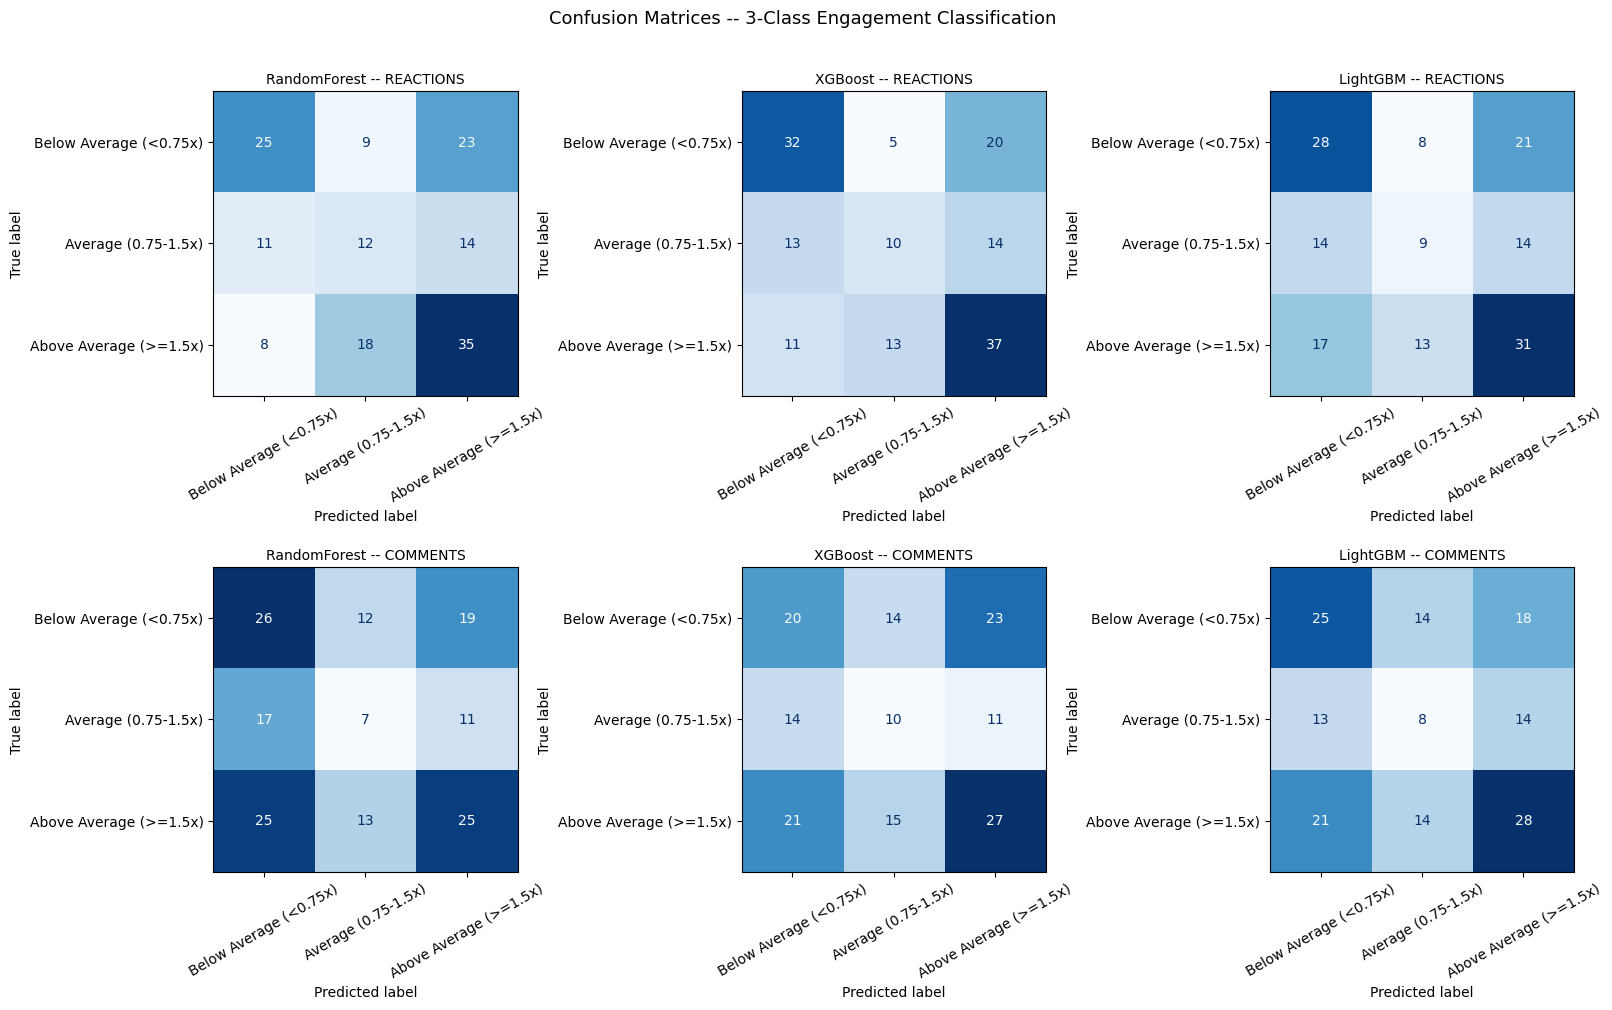

Saved: ../data/09_confusion_matrices_3class.png


In [10]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

models_r = [('RandomForest', rf3_r), ('XGBoost', xgb3_r), ('LightGBM', lgb3_r)]
models_c = [('RandomForest', rf3_c), ('XGBoost', xgb3_c), ('LightGBM', lgb3_c)]

for j, (name, m) in enumerate(models_r):
    plot_confusion(m, X_test, yr3_test, 'reactions', name, ax=axes[0,j])
for j, (name, m) in enumerate(models_c):
    plot_confusion(m, X_test, yc3_test, 'comments',  name, ax=axes[1,j])

plt.suptitle('Confusion Matrices -- 3-Class Engagement Classification', fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig('../data/09_confusion_matrices_3class.png', dpi=100, bbox_inches='tight')
plt.show()
print("Saved: ../data/09_confusion_matrices_3class.png")


## 7. Results Summary — 3-Class

In [11]:
res3_df = pd.DataFrame(all_results_3)

print("=" * 60)
print("3-CLASS CLASSIFICATION RESULTS")
print("=" * 60)
for tgt in ['reactions','comments']:
    print(f"\n{tgt.upper()}:")
    sub = res3_df[res3_df['target']==tgt][['model','macro_f1','acc']]
    print(sub.to_string(index=False))

print("\nRandom 3-class baseline: Macro F1 ~ 0.33")


3-CLASS CLASSIFICATION RESULTS

REACTIONS:
       model  macro_f1    acc
RandomForest    0.4457 0.4645
     XGBoost    0.4782 0.5097
    LightGBM    0.4132 0.4387

COMMENTS:
       model  macro_f1    acc
RandomForest    0.3496 0.3742
     XGBoost    0.3543 0.3677
    LightGBM    0.3706 0.3935

Random 3-class baseline: Macro F1 ~ 0.33


## 8. Binary Classification (Above vs Below Baseline)

In [12]:
BINARY_NAMES = {0: 'Below baseline (<1.0x)', 1: 'At/Above baseline (>=1.0x)'}
all_results_2 = []

def evaluate_binary(model, X_te, y_te, target='reactions', name='Model'):
    yp       = model.predict(X_te)
    macro_f1 = f1_score(y_te, yp, average='macro')
    acc      = accuracy_score(y_te, yp)
    print(f"  [{name}] {target.upper()} (binary)")
    print(f"    Macro F1: {macro_f1:.4f}  |  Accuracy: {acc:.4f} ({acc*100:.1f}%)")
    print(classification_report(y_te, yp,
          target_names=[BINARY_NAMES[i] for i in [0,1]], zero_division=0))
    return dict(model=name, target=target+'_binary', macro_f1=round(macro_f1,4), acc=round(acc,4))

print("Binary RandomForest")
rf2_r = RandomForestClassifier(n_estimators=400, max_depth=10,
        min_samples_split=20, min_samples_leaf=10,
        class_weight='balanced', random_state=42, n_jobs=-1)
rf2_r.fit(X_train, yr2_train)
rf2_c = RandomForestClassifier(n_estimators=200, max_depth=10,
        min_samples_split=20, min_samples_leaf=10,
        class_weight='balanced', random_state=42, n_jobs=-1)
rf2_c.fit(X_train, yc2_train)
all_results_2.append(evaluate_binary(rf2_r, X_test, yr2_test, 'reactions', 'RandomForest'))
all_results_2.append(evaluate_binary(rf2_c, X_test, yc2_test, 'comments',  'RandomForest'))


Binary RandomForest
  [RandomForest] REACTIONS (binary)
    Macro F1: 0.4501  |  Accuracy: 0.4516 (45.2%)
                            precision    recall  f1-score   support

    Below baseline (<1.0x)       0.40      0.44      0.42        70
At/Above baseline (>=1.0x)       0.50      0.46      0.48        85

                  accuracy                           0.45       155
                 macro avg       0.45      0.45      0.45       155
              weighted avg       0.46      0.45      0.45       155

  [RandomForest] COMMENTS (binary)
    Macro F1: 0.4180  |  Accuracy: 0.4258 (42.6%)
                            precision    recall  f1-score   support

    Below baseline (<1.0x)       0.35      0.35      0.35        69
At/Above baseline (>=1.0x)       0.48      0.49      0.49        86

                  accuracy                           0.43       155
                 macro avg       0.42      0.42      0.42       155
              weighted avg       0.42      0.43      0.4

In [13]:
print("Binary XGBoost")
sw2_r = compute_sample_weight('balanced', yr2_train)
sw2_c = compute_sample_weight('balanced', yc2_train)
xgb2_r = xgb.XGBClassifier(n_estimators=400, max_depth=5, learning_rate=0.05,
         min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
         use_label_encoder=False, eval_metric='logloss',
         random_state=42, n_jobs=-1, verbosity=0)
xgb2_r.fit(X_train, yr2_train, sample_weight=sw2_r)
xgb2_c = xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
         min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
         use_label_encoder=False, eval_metric='logloss',
         random_state=42, n_jobs=-1, verbosity=0)
xgb2_c.fit(X_train, yc2_train, sample_weight=sw2_c)
all_results_2.append(evaluate_binary(xgb2_r, X_test, yr2_test, 'reactions', 'XGBoost'))
all_results_2.append(evaluate_binary(xgb2_c, X_test, yc2_test, 'comments',  'XGBoost'))

print("Binary LightGBM")
lgb2_r = lgb.LGBMClassifier(n_estimators=400, max_depth=5, learning_rate=0.05,
         num_leaves=20, min_child_samples=20, subsample=0.8,
         colsample_bytree=0.8, class_weight='balanced',
         random_state=42, n_jobs=-1, verbose=-1)
lgb2_r.fit(X_train, yr2_train)
lgb2_c = lgb.LGBMClassifier(n_estimators=200, max_depth=5, learning_rate=0.05,
         num_leaves=20, min_child_samples=20, subsample=0.8,
         colsample_bytree=0.8, class_weight='balanced',
         random_state=42, n_jobs=-1, verbose=-1)
lgb2_c.fit(X_train, yc2_train)
all_results_2.append(evaluate_binary(lgb2_r, X_test, yr2_test, 'reactions', 'LightGBM'))
all_results_2.append(evaluate_binary(lgb2_c, X_test, yc2_test, 'comments',  'LightGBM'))


Binary XGBoost
  [XGBoost] REACTIONS (binary)
    Macro F1: 0.4692  |  Accuracy: 0.4710 (47.1%)
                            precision    recall  f1-score   support

    Below baseline (<1.0x)       0.42      0.46      0.44        70
At/Above baseline (>=1.0x)       0.52      0.48      0.50        85

                  accuracy                           0.47       155
                 macro avg       0.47      0.47      0.47       155
              weighted avg       0.47      0.47      0.47       155

  [XGBoost] COMMENTS (binary)
    Macro F1: 0.4327  |  Accuracy: 0.4387 (43.9%)
                            precision    recall  f1-score   support

    Below baseline (<1.0x)       0.37      0.38      0.37        69
At/Above baseline (>=1.0x)       0.49      0.49      0.49        86

                  accuracy                           0.44       155
                 macro avg       0.43      0.43      0.43       155
              weighted avg       0.44      0.44      0.44       155

Bi

## 9. Feature Importance — Best 3-Class Model

Top 15 Features -- 3-Class Reactions:
                   feature  importance
    text_lexical_diversity    0.061871
  text_avg_sentence_length    0.059622
text_difficult_words_count    0.052536
readability_flesch_kincaid    0.049931
        sentiment_compound    0.048470
   readability_gunning_fog    0.048307
   sentiment_x_readability    0.044697
            sentence_count    0.042181
         base_score_capped    0.038904
        style_number_count    0.038822
             ner_org_count    0.034397
      style_all_caps_words    0.031904
        ner_location_count    0.028636
          ner_person_count    0.024086
            ner_date_count    0.022537


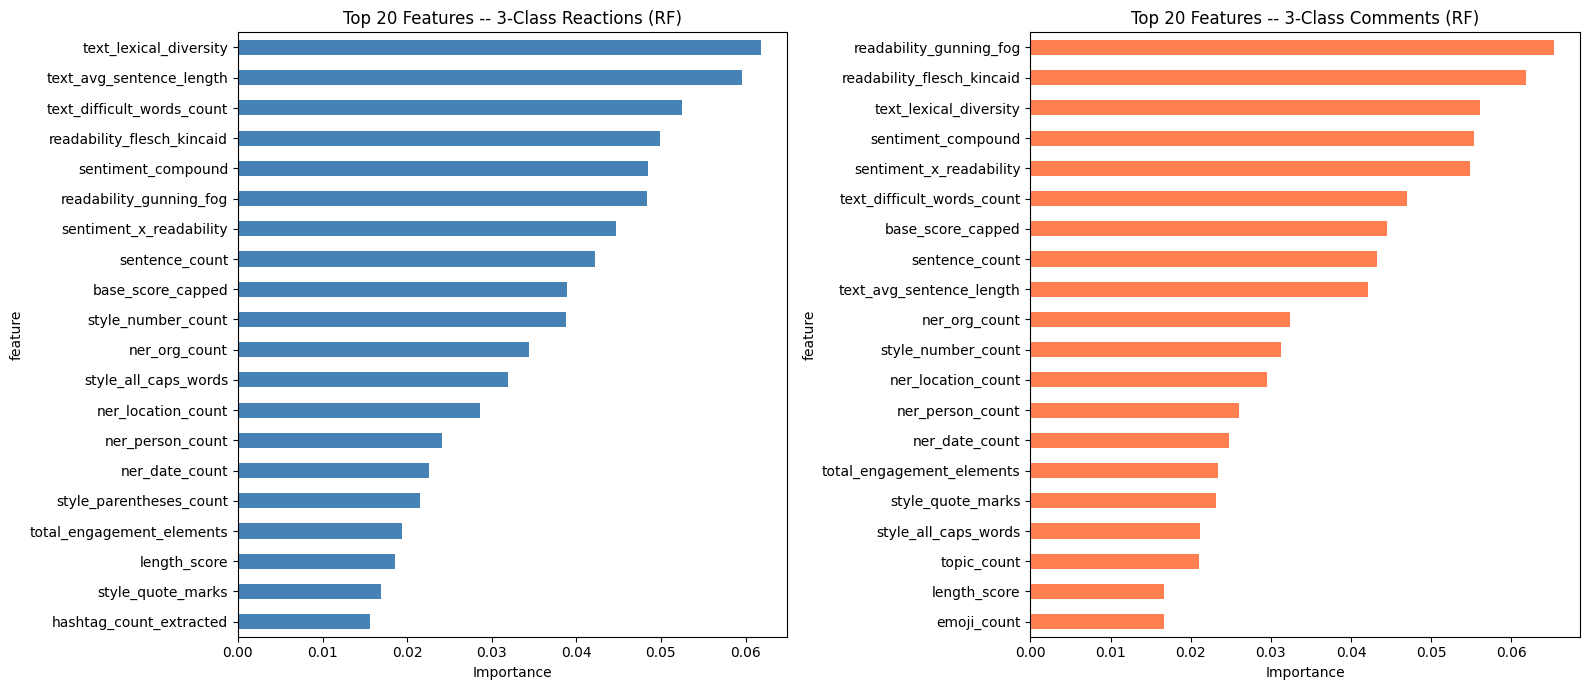

Saved: ../data/09_feature_importance_clf.png


In [14]:
imp_r = pd.DataFrame({'feature': available, 'importance': rf3_r.feature_importances_}
                    ).sort_values('importance', ascending=False).reset_index(drop=True)
imp_c = pd.DataFrame({'feature': available, 'importance': rf3_c.feature_importances_}
                    ).sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 15 Features -- 3-Class Reactions:")
print(imp_r.head(15).to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
imp_r.head(20).sort_values('importance').plot(
    x='feature', y='importance', kind='barh', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Top 20 Features -- 3-Class Reactions (RF)', fontsize=12)
axes[0].set_xlabel('Importance')

imp_c.head(20).sort_values('importance').plot(
    x='feature', y='importance', kind='barh', ax=axes[1], color='coral', legend=False)
axes[1].set_title('Top 20 Features -- 3-Class Comments (RF)', fontsize=12)
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.savefig('../data/09_feature_importance_clf.png', dpi=100, bbox_inches='tight')
plt.show()
print("Saved: ../data/09_feature_importance_clf.png")


## 10. Cross-Validation (Stratified 5-Fold)

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Stratified 5-Fold CV -- RandomForest 3-Class (Reactions):")
cv_f1 = cross_val_score(
    RandomForestClassifier(n_estimators=200, max_depth=10,
        min_samples_split=20, min_samples_leaf=10,
        class_weight='balanced', random_state=42, n_jobs=-1),
    X, yr3, cv=skf, scoring='f1_macro')
print(f"  CV Macro F1 per fold: {cv_f1.round(4)}")
print(f"  Mean: {cv_f1.mean():.4f} +/- {cv_f1.std():.4f}")
print(f"  Random baseline: ~0.33")


Stratified 5-Fold CV -- RandomForest 3-Class (Reactions):
  CV Macro F1 per fold: [0.4334 0.3997 0.4335 0.4406 0.363 ]
  Mean: 0.4140 +/- 0.0292
  Random baseline: ~0.33


## 11. Combined Results Summary

In [16]:
print("=" * 60)
print("FULL RESULTS SUMMARY -- NB09 CLASSIFICATION")
print("=" * 60)

print("\n3-CLASS (Low/Average/High):")
res3_df_print = pd.DataFrame(all_results_3)
print(res3_df_print.to_string(index=False))

print("\nBINARY (Below vs At/Above Baseline):")
res2_df_print = pd.DataFrame(all_results_2)
print(res2_df_print.to_string(index=False))

print("\nBASELINES:")
print("  3-class random Macro F1: ~0.33")
print("  Binary random accuracy:  ~0.50")


FULL RESULTS SUMMARY -- NB09 CLASSIFICATION

3-CLASS (Low/Average/High):
       model    target  macro_f1    acc
RandomForest reactions    0.4457 0.4645
RandomForest  comments    0.3496 0.3742
     XGBoost reactions    0.4782 0.5097
     XGBoost  comments    0.3543 0.3677
    LightGBM reactions    0.4132 0.4387
    LightGBM  comments    0.3706 0.3935

BINARY (Below vs At/Above Baseline):
       model           target  macro_f1    acc
RandomForest reactions_binary    0.4501 0.4516
RandomForest  comments_binary    0.4180 0.4258
     XGBoost reactions_binary    0.4692 0.4710
     XGBoost  comments_binary    0.4327 0.4387
    LightGBM reactions_binary    0.5062 0.5097
    LightGBM  comments_binary    0.4968 0.4968

BASELINES:
  3-class random Macro F1: ~0.33
  Binary random accuracy:  ~0.50


## 12. Conclusions

### What This Approach Adds vs NB08 (LOO Regression)

| Aspect | NB08 (LOO Regression) | NB09 (Classification) |
|--------|----------------------|----------------------|
| Output | Exact log-relative ratio | Class: Low/Average/High |
| Task difficulty | Harder (exact number) | Easier (category) |
| Primary metric | Spearman rho | Macro F1 |
| Interpretability | Requires back-transformation | Direct class prediction |
| Use case | Ranking posts by expected performance | Go / No-go decision on content |

### Interpretation Guide

**3-Class:**
- Macro F1 > 0.45: model is reliably distinguishing engagement tiers
- Macro F1 = 0.33: no better than random guessing

**Binary:**
- Accuracy > 60%: model correctly predicts above vs below baseline most of the time
- Accuracy = 50%: coin flip

### Practical Use

The binary model is most actionable for a content recommendation system:

```python
# Predict whether a draft post will outperform the author's typical engagement
prob_above = model.predict_proba(content_features)[0][1]  # probability of class 1
if prob_above > 0.6:
    print("This post is likely to outperform your typical engagement.")
else:
    print("This post may underperform. Consider revising the hook or structure.")
```

### Next Steps

1. If classification works well: combine with NB08 regression for a two-stage model (class + magnitude)
2. Collect more data: 772 posts is small; doubling to 1500+ would improve stability
3. Add posting time features (day of week, hour): likely 10-20% additional variance explained
4. Explore sentence embeddings (BERT/SBERT) as features for richer text representation
